In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random
import string

def label_generator():
  existed_label = set()
  
  def get_random_string(length=8):
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str
  
  while True:
    random_generated_label = get_random_string()
    if random_generated_label not in existed_label:
      existed_label.add(random_generated_label)
      break

  return random_generated_label

In [3]:
class Value:
  
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    #  grad to 0 means it has no effect
    self.grad = 0
    # Use set to filter out duplicate Value in children tuple
    self._prev = set(_children)
    self._op = _op
    if label == "":
      self.label = label_generator()
    else:
      self.label = label
  
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")
    return out
  
  def __sub__(self, other):
    out = Value(self.data - other.data, (self, other), "-")
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), "*")
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), "tanh")
    return out
  
# a = Value(2.0, label="a")
# b = Value(-3.0, label="b")
# c = Value(6.0, label="c")
# e = b * c
# e.label = "e"
# d = a + e
# d.label = "d"
# f = Value(-2.0, label="f")
# L = d * f
# L.label = "L"


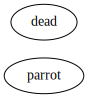

In [4]:
from graphviz import Digraph
ps = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

ps.node(name='parrot')
ps.node(name='dead')
# ps.edge('parrot', 'dead')

ps

In [5]:
from graphviz import Digraph

def get_topo_order(root):
  topo_order = []
  visited = set()
  def topo_sort_dfs(node, visited, topo_order):
    if node not in visited:
      visited.add(node)
      for child in node._prev:
        topo_sort_dfs(child, visited, topo_order)
      topo_order.append(node)
  topo_sort_dfs(root, visited, topo_order)
  return topo_order

# print(get_topo_order(d))

def draw_dot_using_topo(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  topo_order = get_topo_order(root)
  for node in topo_order[::-1]:
    node_uid = str(id(node))
    dot.node(name = node_uid,
             label = "{0} | data {1:.4f} | grad {2:.4f}".format(node.label, node.data, node.grad),
             # label = "{{ {0} | data {1:.4f} | grad {2:.4f} }}".format(node.label, node.data, node.grad), 
             shape = "record")
    if node._op:
      dot.node(name = node_uid + node._op,
               label = node._op)
      dot.edge(node_uid + node._op, node_uid)
      for child in node._prev:
        child_uid = str(id(child)) 
        dot.edge(child_uid, node_uid + node._op)
  return dot

# draw_dot_using_topo(L)


In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# draw_dot(d)

-1.9999999999953388


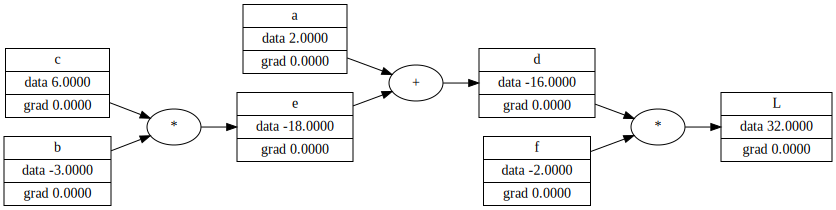

In [7]:
# Calcuate numeric differentiation of L with respect to a
def lol():
  h = 0.0001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(6.0, label="c")
  e = b * c
  e.label = "e"
  d = a + e
  d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f
  L.label = "L"
  L1 = L.data

  a = Value(2.0 + h, label="a")
  b = Value(-3.0, label="b")
  c = Value(6.0, label="c")
  e = b * c
  e.label = "e"
  d = a + e
  d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f
  L.label = "L"
  L2 = L.data

  print((L2 - L1) / h)

lol()

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(6.0, label="c")
e = b * c
e.label = "e"
d = a + e
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

draw_dot_using_topo(L)



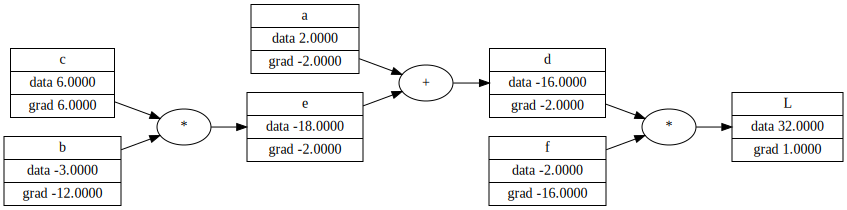

In [8]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
a.grad = d.grad * 1.0
e.grad = d.grad * 1.0
b.grad = e.grad * c.data
c.grad = e.grad * b.data

draw_dot_using_topo(L)

Value(data=27.760448)


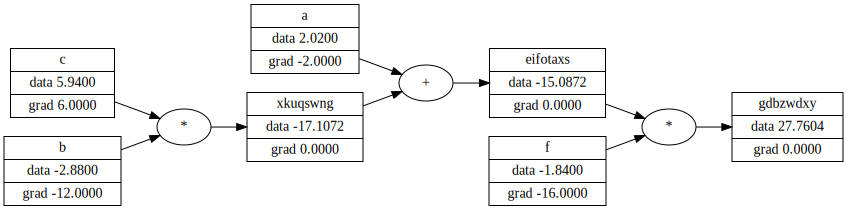

In [9]:
a.data -= 0.01 * a.grad
b.data -= 0.01 * b.grad
c.data -= 0.01 * c.grad
f.data -= 0.01 * f.grad

e = b * c
d = a + e
L = d * f

print(L)
draw_dot_using_topo(L)

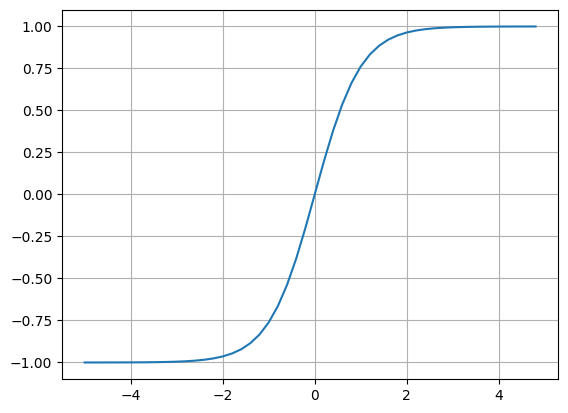

In [10]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

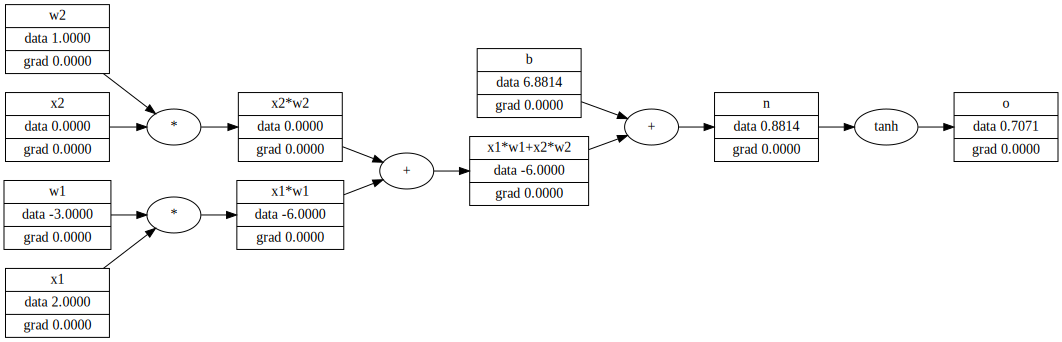

In [11]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# wights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.881373, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

draw_dot_using_topo(o)

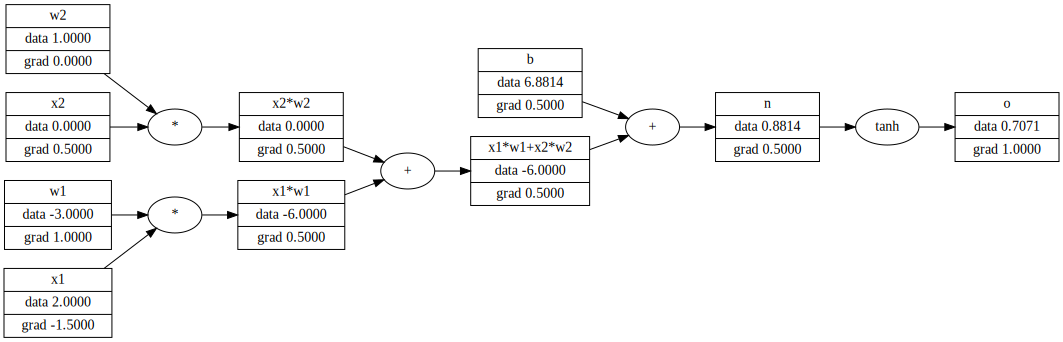

In [12]:
o.grad = 1

n.grad = (1 - o.data**2)
x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad


draw_dot_using_topo(o)

In [48]:
class Value:
  
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    # grad to 0 means it has no effect
    self.grad = 0
    # Set backward function nothing to do by defau;t
    self._backward = lambda: None
    # Use set to filter out duplicate Value in children tuple
    self._prev = set(_children)
    self._op = _op
    if label == "":
      self.label = label_generator()
    else:
      self.label = label
  
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    # To prevent add with an object which is not a Value
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      # Apply chain rule and partial derivatives rule
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out
  
  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
    # exponent is a contanst here, so it can't be set as a child of out
    out = Value(self.data ** other, (self, ), "**{0}".format(other))

    def _backward():
      self.grad += out.grad * (other * self.data**(other-1))
    out._backward = _backward

    return out

  # 2 * Value == 2.__mul__(Value) fails into this method
  def __rmul__(self, other):
    # Just swap the order of two operands
    return self * other
  
  def __truediv__(self, other):
    return self * other**-1



  def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t**2) * out.grad
      print("backward in tanh grad {:.4f}".format(self.grad))
    out._backward = _backward

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), label="exp")

    def _backward():
      self.grad += out.grad * out.data
    out._backward = _backward

    return out


  def backward(self):
    topo = []
    visited = set()
    
    def dfs_visit(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          dfs_visit(child)
        topo.append(node)
    
    dfs_visit(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
      
    

backward in tanh grad 0.5000


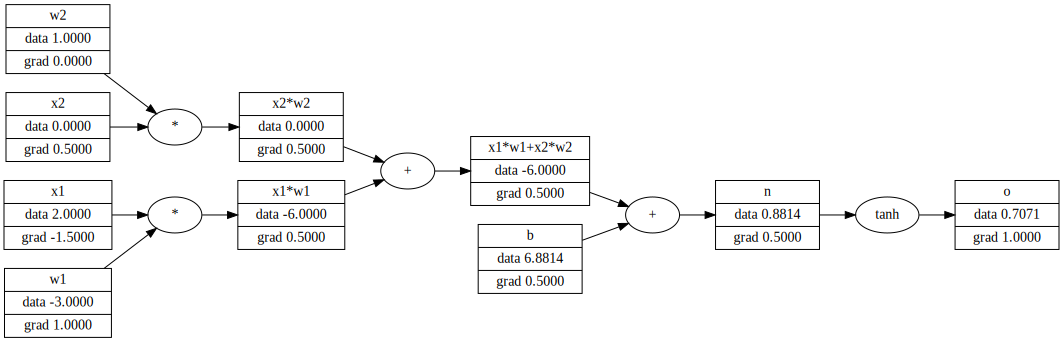

In [14]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# wights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.881373, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

# w/o topo sort backward method
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

# w topo sort backward method
# o.backward()

draw_dot_using_topo(o)



In [ ]:
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

In [ ]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")

d = a * b ; d.label = "d"
e = a + b ; e.label = "e"
f = d * e ; f.label = "f"

f.backward()

draw_dot(f)

In [43]:
a = Value(-2.0, label="a")
a + 1
a * 2
# Because Value can not add with an integer
a = Value(2.0, label="a")
b = Value(4.0, label="b")
a / b
b - a

Value(data=2.0)

In [41]:
def func(s=()):
  return set(s)

func(1)

TypeError: 'int' object is not iterable

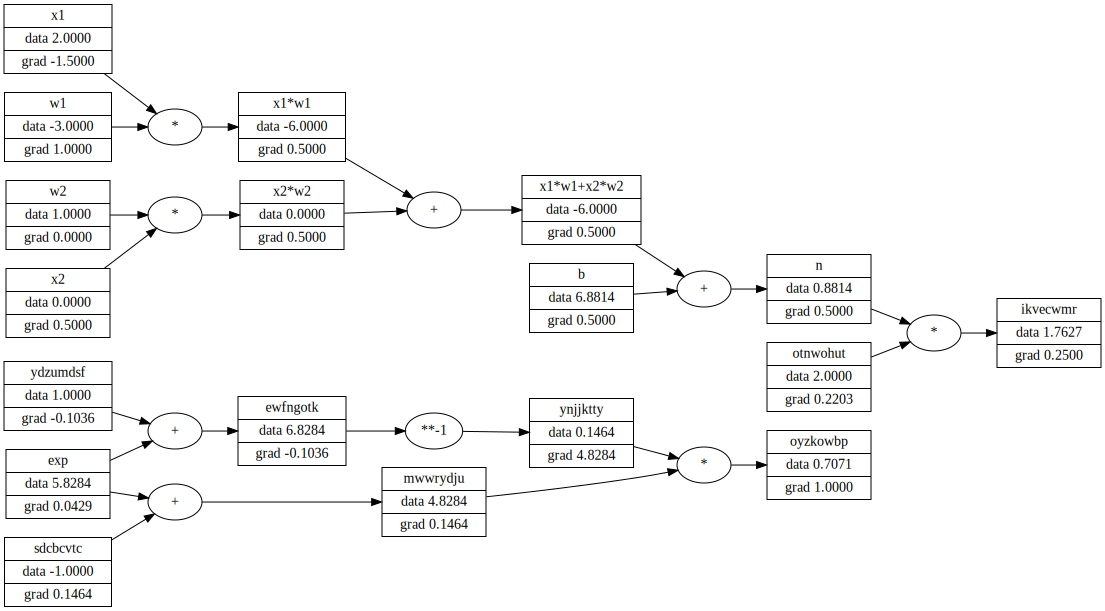

In [49]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# wights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.881373, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1+x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# o = n.tanh(); o.label = "o"
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.backward()
draw_dot_using_topo(o)